# Test of ESIS Reproducibility
_Roy Smart and Charles Kankelborg_

The purpose of this document is to reproduce the ESIS design created by Charles Kankelborg and Hans Courrier.
The original ESIS design was based on the toroidal varied line spacing (TVLS) prescription outlined in Poletto and Thomas (2004), and was adapted to a spherical varied line spacing (SVLS) since the toroidal componentent was too subtle for the grating vendor to reproeduce. Currently the code supporting this document only supports TVLS designs, not SVLS. 
As a result, our reproduced version of ESIS may be more performant.

Set up environment and import required packages.

In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import warnings
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
import pandas as pd
import kgpy.optics
import esis

warnings.filterwarnings('ignore')

## Courrier and Kankelborg ESIS Design (May 8, 2017)

First, load the ESIS design into memory. We'll create two copies of the design: a small one for plotting (matplotlib does poorly with large numbers of rays and you can't see anything anyways) and a larger one for PSF statistics.

In [2]:
pupil_samples = 20
field_samples = 5

esis_optics_small = esis.optics.design.final(pupil_samples=5, field_samples=3)
esis_optics = esis.optics.design.final(pupil_samples=pupil_samples, field_samples=field_samples)

Plotted below is the ESIS optical layout.
For this model of ESIS, we will use a Zemax-based coordinate system where $z$ is the optic axis and also the axis of
symmetry of the primary mirror.
It points from the front aperture plate towards the primary mirror.
$z$ is into the page in the top-left figure, and towards the right in the two figures on the right.
$x$ is a coordinate parallel to the front aperture plate and points to the left in the top-left figure.
$y$ is also parallel to the front aperture plate and points vertically in the top-left figure.

Since ESIS is symmetric about the $z$ axis we only need to model one channel, the other channels are simply rotated
versions of this one.
The dispersion plane of this channel is oriented so that it is parallel to the $x$-$z$ plane.
This is in contrast to the Courrier Zemax design which had the dispersion plane parallel to the $y$-$z$ plane.
We changed the orientation so that the $x$-axis would be parallel to the long axis of the detector.

<IPython.core.display.Javascript object>


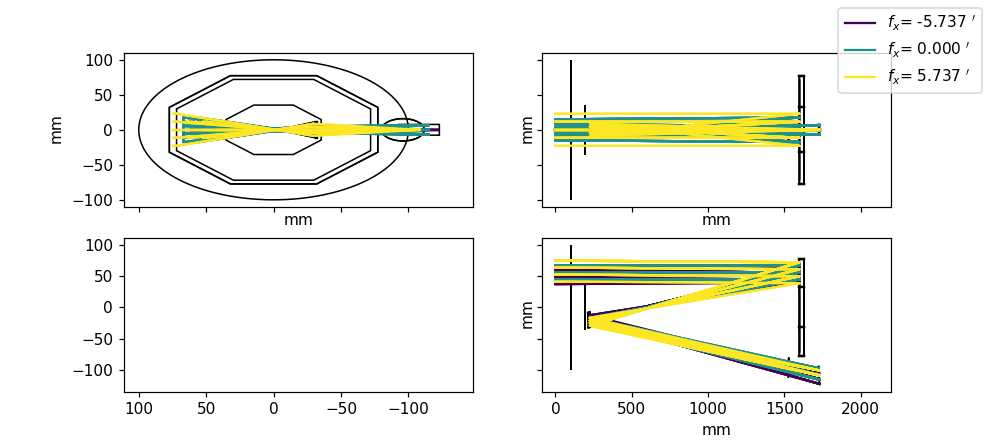

In [3]:
color_axis = kgpy.optics.Rays.axis.field_x
fig1 = esis_optics_small.system.plot_projections(color_axis=color_axis)
fig1.set_figwidth(9)
fig1.set_figheight(4)

Plot the ray sampling across the field stop and the grating

<IPython.core.display.Javascript object>


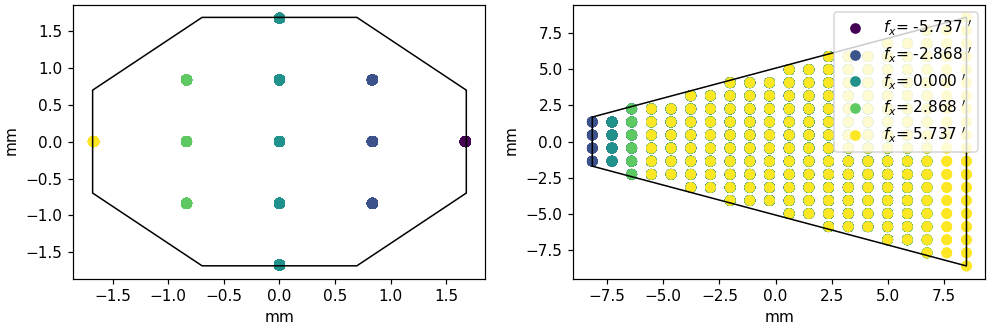

In [4]:
fig2, axs2 = plt.subplots(ncols=2, figsize=(9, 3), constrained_layout=True)
_ = esis_optics.system.plot_footprint(
    ax=axs2[0],
    surf=esis_optics.components.field_stop.surface,
    color_axis=color_axis,
)
axs2[0].get_legend().remove()
_ = esis_optics.system.plot_footprint(
    ax=axs2[1],
    surf=esis_optics.components.grating.surface,
    color_axis=color_axis,
)

Plot the footprint of the rays on the detector.
The O V 630A is on the right and the He I 584A is on the left, hanging off the edge of the detector.

<IPython.core.display.Javascript object>


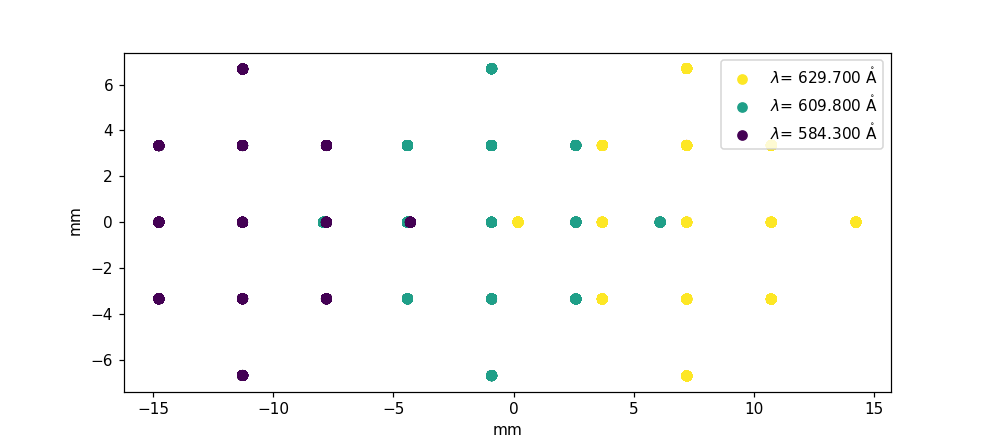

In [5]:
fig3, ax3 = plt.subplots(figsize=(9, 4))
ax3 = esis_optics.system.plot_footprint(ax=ax3)

Plot the point-spread function vs. field angle for both the O V 630A and the He I 584A spectral lines.
Notice that the color scale for each spectral line is different.

<IPython.core.display.Javascript object>


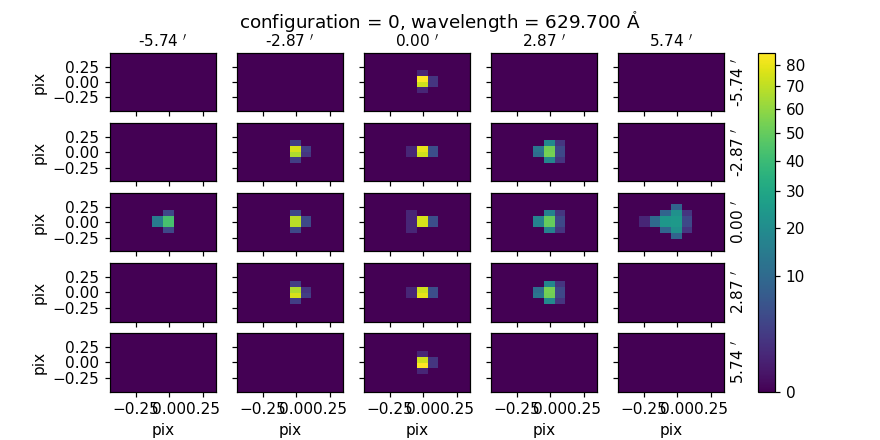

<IPython.core.display.Javascript object>


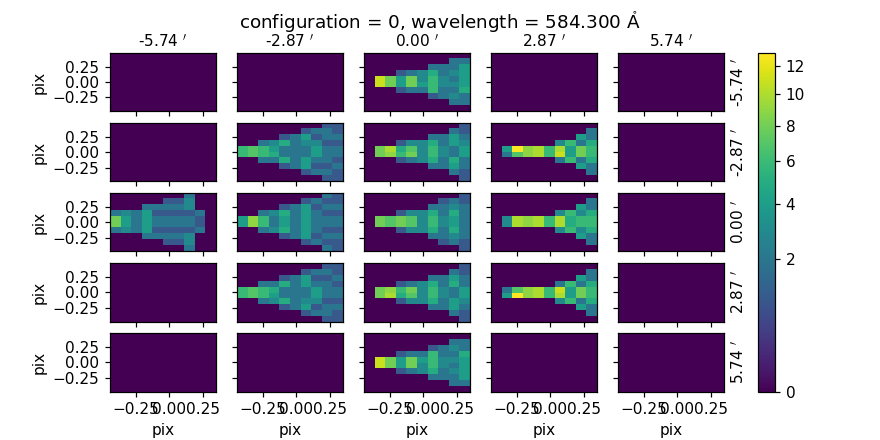

In [6]:
rays = esis_optics.system.image_rays.copy()
rays.position = (rays.position / (2 * esis_optics.components.detector.pix_half_width_x / u.pix)).to(u.pix)
fig4 = rays.plot_pupil_hist2d_vs_field(
    wavlen_index=0,
    relative_to_centroid=(True, True),
    norm=matplotlib.colors.PowerNorm(1/2),
)
fig4.set_figheight(4)
fig4.set_figwidth(8)
fig5 = rays.plot_pupil_hist2d_vs_field(
    wavlen_index=~0,
    relative_to_centroid=(True, True),
    norm=matplotlib.colors.PowerNorm(1/2),
)
fig5.set_figheight(4)
fig5.set_figwidth(8)

## Reproducing the ESIS Design

After assessing the performance of the original ESIS, we are ready to explain our procedure for reproducing the design.
The most significant limitation of our current experiment is that the grating position is assumed to be given.
This experiment instead focuses on reproducing grating radius, grating inclination, grating groove profile, detector
piston and detector inclination.

In [7]:
new_esis_optics = esis.optics.design.from_poletto(pupil_samples=pupil_samples, field_samples=field_samples)
# new_esis.components.grating.groove_density_coeff_linear = 0 / u.mm ** 2
# new_esis.components.grating.groove_density_coeff_quadratic = 0 / u.mm ** 3
new_esis_optics.components.grating.groove_density_coeff_cubic *= 0
new_esis_optics.update()

The table below compares the original parameters of the grating compared to the free parameters of the reproduced
grating.
In this current iteration, almost every parameter is different, all likely caused by the difference in grating
inclination.

In [8]:
g_old = esis_optics.components.grating
g_new = new_esis_optics.components.grating

estr = '{0.value:0.3e} {0.unit:latex}'
fstr = '{0.value:0.3f} {0.unit:latex}'
g_rs_old = fstr.format(g_old.sagittal_radius)
g_rs_new = fstr.format(g_new.sagittal_radius)
g_rt_old = fstr.format(g_old.tangential_radius)
g_rt_new = fstr.format(g_new.tangential_radius[0])
g_phi_old = fstr.format(g_old.inclination.to(u.deg))
g_phi_new = fstr.format(g_new.inclination.to(u.deg))
g_sigma_0_old = fstr.format(g_old.groove_density.to(1 / u.um))
g_sigma_0_new = fstr.format(g_new.groove_density[0].to(1 / u.um))
g_sigma_1_old = fstr.format(g_old.groove_density_coeff_linear.to(1 / u.mm ** 2))
g_sigma_1_new = fstr.format(g_new.groove_density_coeff_linear[0].to(1 / u.mm ** 2))
g_sigma_2_old = estr.format(g_old.groove_density_coeff_quadratic.to(1 / u.mm ** 3))
g_sigma_2_new = estr.format(g_new.groove_density_coeff_quadratic[0].to(1 / u.mm ** 3))
g_sigma_3_old = estr.format(g_old.groove_density_coeff_cubic.to(1 / u.mm ** 4))
g_sigma_3_new = estr.format(g_new.groove_density_coeff_cubic[0].to(1 / u.mm ** 4))
table_1 = pd.DataFrame(data={
    'grating sagittal radius': [g_rs_old, g_rs_new],
    'grating tangential radius': [g_rt_old, g_rt_new],
    'grating inclination': [g_phi_old, g_phi_new],
    'grating groove density': [g_sigma_0_old, g_sigma_0_new],
    'grating linear coefficient': [g_sigma_1_old, g_sigma_1_new],
    'grating quadratic coefficient': [g_sigma_2_old, g_sigma_2_new],
    'grating cubic coefficient': [g_sigma_3_old, g_sigma_3_new],
}).T
column_names = ['SVLS original', 'TVLS reproduction']
table_1.columns = column_names
table_1

,SVLS original,TVLS reproduction
grating sagittal radius,597.830 $\mathrm{mm}$,598.264 $\mathrm{mm}$
grating tangential radius,597.830 $\mathrm{mm}$,595.046 $\mathrm{mm}$
grating inclination,-4.470 $\mathrm{{}^{\circ}}$,-5.515 $\mathrm{{}^{\circ}}$
grating groove density,2.587 $\mathrm{\frac{1}{\mu m}}$,3.150 $\mathrm{\frac{1}{\mu m}}$
grating linear coefficient,0.226 $\mathrm{\frac{1}{mm^{2}}}$,0.617 $\mathrm{\frac{1}{mm^{2}}}$
grating quadratic coefficient,9.314e-04 $\mathrm{\frac{1}{mm^{3}}}$,9.387e-05 $\mathrm{\frac{1}{mm^{3}}}$
grating cubic coefficient,0.000e+00 $\mathrm{\frac{1}{mm^{4}}}$,0.000e+00 $\mathrm{\frac{1}{mm^{4}}}$


In [9]:
sag_sagittal = g_new.surface.sag(5 * u.mm, 0 * u.mm)
sag_tangential = g_new.surface.sag(0 * u.mm, 5 * u.mm)
sag_change = sag_tangential - sag_sagittal
sag_change.to(u.nm)

<Quantity [-113.02329949] nm>

In [10]:
( sag_change / esis_optics.wavelengths[..., 0]).to(u.dimensionless_unscaled)

<Quantity [-1.79487533]>

This next table compares the original parameters of the detector vs. the free parameters of the reproduced detector.
Notice how the detector is much more tilted in the reproduced version than the original.

In [11]:
d_old = esis_optics.components.detector
d_new = new_esis_optics.components.detector

d_z_old = fstr.format(d_old.piston.to(u.mm))
d_z_new = fstr.format(d_new.piston[0])
d_phi_old = fstr.format(d_old.inclination)
d_phi_new = fstr.format(d_new.inclination[0].to(u.deg))

table_2 = pd.DataFrame(data={
    'detector piston': [d_z_old, d_z_new],
    'detector inclination': [d_phi_old, d_phi_new],
}).T
table_2.columns = column_names
table_2

,SVLS original,TVLS reproduction
detector piston,-126.962 $\mathrm{mm}$,-127.032 $\mathrm{mm}$
detector inclination,-12.252 $\mathrm{{}^{\circ}}$,-17.763 $\mathrm{{}^{\circ}}$


Footprint of rays on the detector for the reproduced ESIS design.
Notice how the O V 630 A line is not placed correctly.
This likely accounts for some of the deviation in grating inclination shown in the table above.

<IPython.core.display.Javascript object>


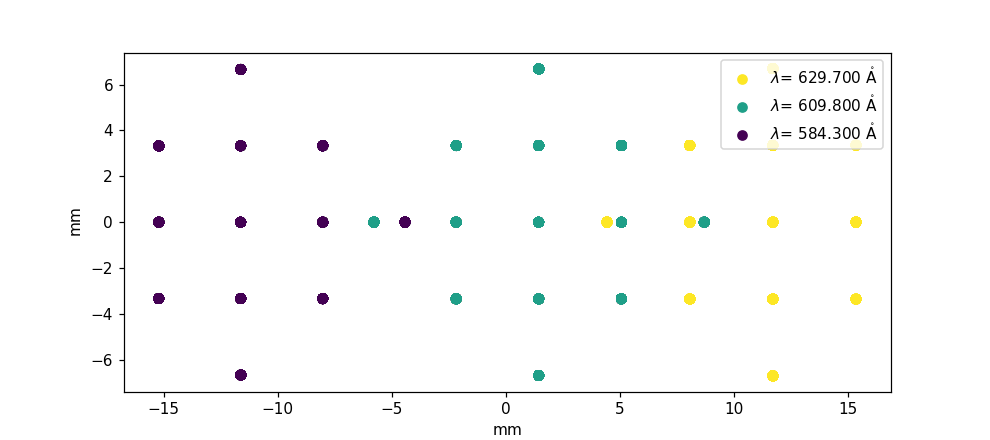

In [12]:
fig6, ax6 = plt.subplots(figsize=(9, 4))
ax6 = new_esis_optics.system.plot_footprint(ax=ax6)

Point-spread function of reproduced ESIS vs. field angle for both the O V 630A and the He I 584A spectral lines.
Note how the focus is better in the 584 A line than ESIS.
This possibly explains the discrepancy in the detector inclination.

<IPython.core.display.Javascript object>


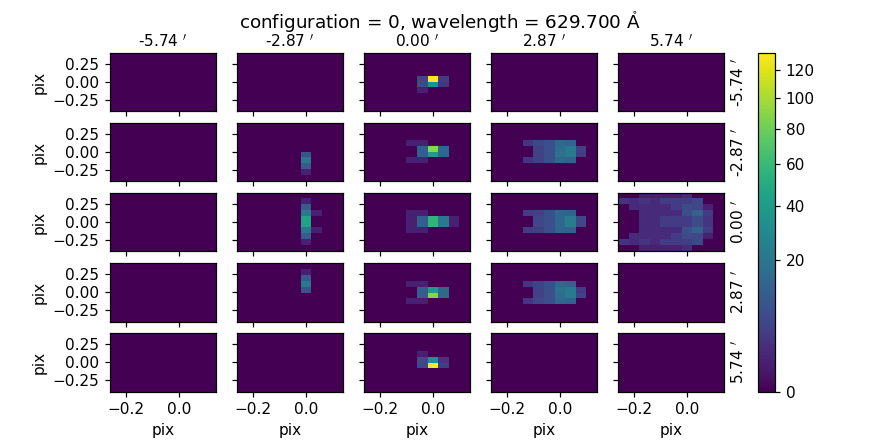

<IPython.core.display.Javascript object>


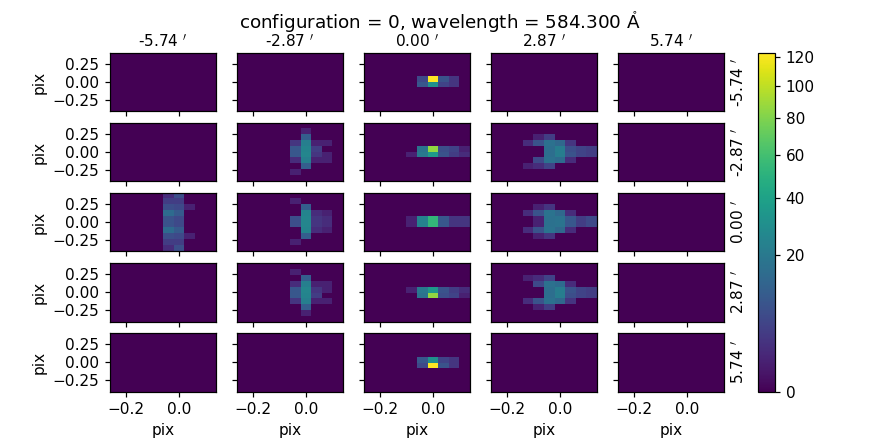

In [13]:
rays = new_esis_optics.system.image_rays.copy()
rays.position = (rays.position / (2 * esis_optics.components.detector.pix_half_width_x / u.pix)).to(u.pix)
fig7 = rays.plot_pupil_hist2d_vs_field(
    wavlen_index=0,
    relative_to_centroid=(True, True),
    norm=matplotlib.colors.PowerNorm(1/2),
)
fig7.set_figheight(4)
fig7.set_figwidth(8)
fig8 = rays.plot_pupil_hist2d_vs_field(
    wavlen_index=~0,
    relative_to_centroid=(True, True),
    norm=matplotlib.colors.PowerNorm(1/2),
)
fig8.set_figheight(4)
fig8.set_figwidth(8)

In [14]:
new_esis_optics.components.grating

Grating(name=grating, tangential_radius=<Quantity [595.04570551] mm>, sagittal_radius=<Quantity 598.26439124 mm>, nominal_input_angle=<Quantity 0. deg>, nominal_output_angle=<Quantity 0. deg>, groove_density=<Quantity [0.00031496] 1 / Angstrom>, groove_density_coeff_linear=<Quantity [6.16580889e-08] 1 / (Angstrom mm)>, groove_density_coeff_quadratic=<Quantity [9.38738107e-12] 1 / (Angstrom mm2)>, groove_density_coeff_cubic=<Quantity [0.] 1 / (Angstrom mm3)>, piston=<Quantity 1375.63342359 mm>, channel_radius=<Quantity 21.81390567 mm>, channel_angle=<Quantity 180. deg>, inclination=<Quantity -0.0962529 rad>, aper_half_angle=<Quantity 22.5 deg>, aper_decenter_x=<Quantity -21.81390567 mm>, inner_clear_radius=<Quantity 14.36596765 mm>, outer_clear_radius=<Quantity 29.2618437 mm>, inner_border_width=<Quantity 4.86 mm>, outer_border_width=<Quantity 2. mm>, side_border_width=<Quantity 2. mm>, dynamic_clearance=<Quantity 1.25 mm>, substrate_thickness=<Quantity 10. mm>)

In [15]:
esis_optics.components.grating

Grating(name=grating, tangential_radius=<Quantity 597.83 mm>, sagittal_radius=<Quantity 597.83 mm>, nominal_input_angle=<Quantity 0. deg>, nominal_output_angle=<Quantity 0. deg>, groove_density=<Quantity 2.5866086 1 / um>, groove_density_coeff_linear=<Quantity 0.00022647 1 / (mm um)>, groove_density_coeff_quadratic=<Quantity 9.31414854e-07 1 / (mm2 um)>, groove_density_coeff_cubic=<Quantity 0. 1 / mm4>, piston=<Quantity 1374.7 mm>, channel_radius=<Quantity 20.74999998 mm>, channel_angle=<Quantity 180. deg>, inclination=<Quantity -4.46956724 deg>, aper_half_angle=<Quantity 22.5 deg>, aper_decenter_x=<Quantity -20.74999998 mm>, inner_clear_radius=<Quantity 12.58999998 mm>, outer_clear_radius=<Quantity 29.23999998 mm>, inner_border_width=<Quantity 4.86 mm>, outer_border_width=<Quantity 2. mm>, side_border_width=<Quantity 2. mm>, dynamic_clearance=<Quantity 1.25 mm>, substrate_thickness=<Quantity 10. mm>)